In [1]:
########### c'est cette version qu'il faut installer car toute les version que j'installe ici ne marche pas j;ai pris celle qui marche sur mon pc
########## Ne pas executer deux fois #############

## la commande %%capture pour supprimer les sorties des cellules de code

%%capture
!pip install --upgrade tensorflow==2.12.0
!pip install transformers==4.37.1


In [1]:
########### c'est cette version qu'il faut installer car toute les version que j'installe ici ne marche pas j;ai pris celle qui marche sur mon pc


import tensorflow as tf
import transformers

print("Version de TensorFlow :", tf.__version__)
print("Version de Transformers :", transformers.__version__)

Version de TensorFlow : 2.12.0
Version de Transformers : 4.37.1


In [2]:
from google.colab import drive
import zipfile
import os
import pandas as pd

import shutil


drive.mount('/content/drive')

chemin_zip_heavy_attacks = "/content/drive/My Drive/yvanolfotso/dataset/AttacksHeavy.zip"
chemin_zip_heavy_benign = "/content/drive/My Drive/yvanolfotso/dataset/BenignHeavy.zip"

chemin_zip_light_attacks = "/content/drive/My Drive/yvanolfotso/dataset/AttacksLight.zip"
chemin_zip_light_benign = "/content/drive/My Drive/yvanolfotso/dataset/BenignLight.zip"


# Fonction pour extraire mes fichiers zip
def extraire_zip(chemin_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/extraction_temp")

# Fonction pour charger les fichiers CSV d'un type spécifique (stateful ou stateless)
def charger_concatener_donnees(sous_dossier, prefixe):
    fichiers_csv = [f for f in os.listdir(f"{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    dataframes = [pd.read_csv(f"{sous_dossier}/{f}") for f in fichiers_csv]
    return pd.concat(dataframes, ignore_index=True)


# Extraire les fichiers zip
extraire_zip(chemin_zip_heavy_attacks)
extraire_zip(chemin_zip_heavy_benign)
extraire_zip(chemin_zip_light_attacks)
extraire_zip(chemin_zip_light_benign)

# Charger et concaténer les données de la même manière que vous l'avez fait auparavant
stateful_heavy_attack_data = charger_concatener_donnees("/content/extraction_temp/AttacksHeavy", "stateful")
stateful_heavy_benign_data = charger_concatener_donnees("/content/extraction_temp/BenignHeavy", "stateful")
stateless_heavy_attack_data = charger_concatener_donnees("/content/extraction_temp/AttacksHeavy", "stateless")
stateless_heavy_benign_data = charger_concatener_donnees("/content/extraction_temp/BenignHeavy", "stateless")

stateful_light_attack_data = charger_concatener_donnees("/content/extraction_temp/AttacksLight", "stateful")
stateful_light_benign_data = charger_concatener_donnees("/content/extraction_temp/BenignLight", "stateful")
stateless_light_attack_data = charger_concatener_donnees("/content/extraction_temp/AttacksLight", "stateless")
stateless_light_benign_data = charger_concatener_donnees("/content/extraction_temp/BenignLight", "stateless")

# Supprimer le répertoire temporaire après avoir terminé
if os.path.exists("/content/extraction_temp"):
    shutil.rmtree("/content/extraction_temp")


#### concatenation  sur axis = 0 ########

print(" Heavy attack")

heavy_attack = pd.concat([stateful_heavy_attack_data, stateless_heavy_attack_data], axis=0)
print(heavy_attack.shape)

#### j'ajoute la classe / label ######

heavy_attack['class'] = 'heavy_attacks'
print(heavy_attack.shape)

print(" \n")
print(" Heavy Bengnin")

heavy_bengin = pd.concat([stateful_heavy_benign_data, stateless_heavy_benign_data], axis=0)
print(heavy_bengin.shape)

#### j'ajoute la classe / label ######

heavy_bengin['class'] = 'heavy_bengnin'
print(heavy_bengin.shape)

print(" \n")
print(" Light attack")

light_attack = pd.concat([stateful_light_attack_data, stateless_light_attack_data], axis=0)
print(light_attack.shape)

#### j'ajoute la classe / label ######
light_attack['class'] = 'light_attacks'
print(light_attack.shape)


print(" \n")
print(" Light Bengnin")

light_bengin = pd.concat([stateful_light_benign_data, stateless_light_benign_data], axis=0)
print(light_bengin.shape)

#### j'ajoute la classe / label ######
light_bengin['class'] = 'light_bengnin'
print(light_bengin.shape)


################################### CONCATENATION Final des donnee sur axis = 0 #########################

final_data = pd.concat([heavy_attack, heavy_bengin,light_attack,light_bengin], axis=0, ignore_index=True)

# Suppression colonnes redondantes dans les données catégorielles
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# Vérifier les dimensions du jeu de données final
print("final dataset size \n")
print(final_data.shape)


Mounted at /content/drive
 Heavy attack
(323698, 42)
(323698, 43)
 

 Heavy Bengnin
(250710, 42)
(250710, 43)
 

 Light attack
(53978, 42)
(53978, 43)
 

 Light Bengnin
(82859, 42)
(82859, 43)
final dataset size 

(711245, 43)


In [3]:
################## Les features ont deja été selectionné avec le code de feature selection dataset 3.  ####################
################## Mais actuellement il faut des jour pour pour que j'obtiens les resultat vue la taille des données d'OU POUR UN DEBUT J'UTILISE LES CARACTERISTIQUE SELCTIONNEE AVEC LE [GOA-GA] DU PAPIER DE 2024

# X_numerical = final_data.select_dtypes(include=['int64', 'float64'])
# X_categorical = final_data.select_dtypes(exclude='number').drop('class', axis=1)

X_numerical = final_data[['rr','A_frequency','FQDN_count','upper','lower','numeric','entropy','special', 'labels', 'labels_max','labels_average','len']]

X_categorical = final_data[['rr_type','unique_ttl','timestamp', 'longest_word', 'sld']]

y = final_data['class']

print(X_numerical.shape)
print(X_categorical.shape)

print(y.shape)
print(final_data.shape)



(711245, 12)
(711245, 5)
(711245,)
(711245, 43)


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

if X_numerical.isnull().any().any():
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)
    scaler = MinMaxScaler()
    scaler.fit(X_numerical_imputed)
    scaled_numeric_features = scaler.transform(X_numerical_imputed)
    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_imputed.columns)
    print(scaled_df)

    total_size = scaled_df.shape
    print("Taille totale des caractéristiques numériques après transformations :", total_size)
else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")




             rr  A_frequency  FQDN_count    upper     lower   numeric  \
0       0.00000     0.000000    0.598390  0.02655  0.306263  0.544945   
1       0.00000     0.000000    0.598390  0.02655  0.306263  0.544945   
2       0.00000     0.000000    0.598390  0.02655  0.306263  0.544945   
3       0.00000     0.000000    0.598390  0.02655  0.306263  0.544945   
4       0.00000     0.000000    0.598390  0.02655  0.306263  0.544945   
...         ...          ...         ...      ...       ...       ...   
711240  0.07015     0.070149    0.735294  0.00000  0.294118  0.916667   
711241  0.07015     0.070149    0.647059  0.00000  0.294118  0.666667   
711242  0.07015     0.070149    0.647059  0.00000  0.294118  0.666667   
711243  0.07015     0.070149    0.735294  0.00000  0.294118  0.916667   
711244  0.07015     0.070149    0.735294  0.00000  0.294118  0.916667   

         entropy   special    labels  labels_max  labels_average       len  
0       0.546119  0.567919  0.634367    0.2080

In [5]:
from sklearn.impute import SimpleImputer

if X_categorical.isnull().any().any():
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)

else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
        rr_type             unique_ttl                   timestamp  \
0       {'PTR'}                 [1, 1]  2020-11-22 12:54:35.110354   
1         set()                    [1]  2020-11-22 12:54:35.110354   
2       {'PTR'}  [1, 1, 1, 1, 1, 1, 1]  2020-11-22 12:54:35.110354   
3       {'PTR'}                  [255]  2020-11-22 12:54:35.110354   
4       {'PTR'}                 [1, 1]  2020-11-22 12:54:35.110354   
...         ...                    ...                         ...   
711240  {'PTR'}                 [1, 1]  2020-11-21 18:09:47.739213   
711241  {'PTR'}                 [1, 1]  2020-11-21 18:09:48.974702   
711242  {'PTR'}                 [1, 1]  2020-11-21 18:09:49.385002   
711243  {'PTR'}                 [1, 1]  2020-11-21 18:09:49.797486   
711244  {'PTR'}                 [1, 1]  2020-11-21 18:09:50.207729   

       longest_word  sld  
0                 2  192  
1                 2  192  
2                 2  192  
3                 2  192  
4      

In [6]:
from transformers import DistilBertTokenizer, DistilBertModel

# Créer un tokenizer DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
categorical_features = [X_categorical_imputed[col].astype(str).tolist() for col in X_categorical_imputed.columns]
combined_texts = [' '.join([f"{col_value}" for col_value in row]) for row in zip(*categorical_features)]

# Tokeniser les textes combinés
tokens = tokenizer(combined_texts, padding=True, truncation=True, return_tensors='tf', max_length=64)
print(tokens)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

{'input_ids': <tf.Tensor: shape=(711245, 61), dtype=int32, numpy=
array([[ 101, 1063, 1005, ...,    0,    0,    0],
       [ 101, 2275, 1006, ...,    0,    0,    0],
       [ 101, 1063, 1005, ...,    0,    0,    0],
       ...,
       [ 101, 1063, 1005, ...,    0,    0,    0],
       [ 101, 1063, 1005, ...,    0,    0,    0],
       [ 101, 1063, 1005, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(711245, 61), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


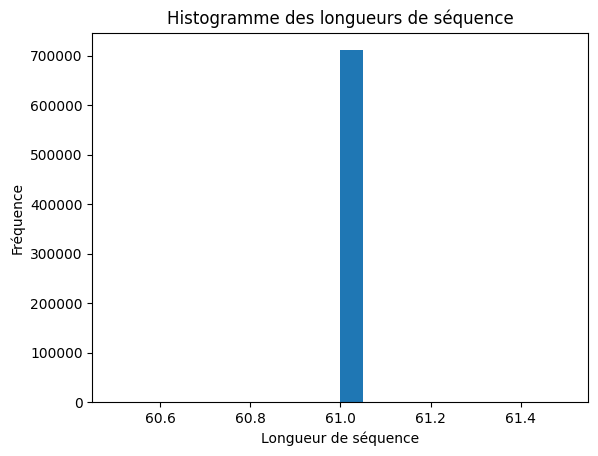

In [7]:
import matplotlib.pyplot as plt

sequence_lengths = [len(token_ids) for token_ids in tokens['input_ids'].numpy()]
plt.hist(sequence_lengths, bins=20)
plt.title('Histogramme des longueurs de séquence')
plt.xlabel('Longueur de séquence')
plt.ylabel('Fréquence')
plt.show()

In [8]:
max_sequence_length = max(sequence_lengths)

indice_plus_longue_sequence = sequence_lengths.index(max_sequence_length)

longueur_plus_longue_sequence = sequence_lengths[indice_plus_longue_sequence]

print(f"Longueur maximale du vecteur : {max_sequence_length}")
print(f"Longueur de la plus longue séquence : {longueur_plus_longue_sequence}")


Longueur maximale du vecteur : 61
Longueur de la plus longue séquence : 61


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import  LabelEncoder

# Entrées pour l'entraînement
data_num = scaled_df
data_text = pad_sequences(tokens['input_ids'].numpy(), maxlen=max_sequence_length, padding='post')

print("Shape of data_num:", data_num.shape)

print("Shape of data_text:", data_text.shape)

print("Shape of labels:", y.shape)

# Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes d'origine associées aux classes encodées:", label_encoder.classes_)
print(y_encoded)

Shape of data_num: (711245, 12)
Shape of data_text: (711245, 61)
Shape of labels: (711245,)
Classes d'origine associées aux classes encodées: ['heavy_attacks' 'heavy_bengnin' 'light_attacks' 'light_bengnin']
[0 0 0 ... 3 3 3]


In [10]:
print(type(data_text))

print(tokens['input_ids'].dtype)

<class 'numpy.ndarray'>
<dtype: 'int32'>


In [11]:
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras import layers, Model

# Entrées
input_num = layers.Input(shape=(scaled_df.shape[1],))
input_text_tokens = layers.Input(shape=(data_text.shape[1],), dtype=tf.int32)

# Branches du modèle
# Branche numérique - FFN
num_branch = layers.Dense(64, activation='relu')(input_num)
num_branch = layers.Dense(32, activation='relu')(num_branch)

# Branche textuelle - DistilBERT
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
outputs = distilbert_model(input_text_tokens)
text_output = outputs.last_hidden_state[:, 0, :]

# Fusion des branches
merged = layers.concatenate([num_branch, text_output])

# Couches supplémentaires après la fusion
merged = layers.Dropout(0.5)(merged)
merged = layers.Dense(16, activation='relu')(merged)
output = layers.Dense(4, activation='softmax')(merged)

# Création et compilation du modèle
model = Model(inputs=[input_num, input_text_tokens], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 61)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           832         ['input_1[0][0]']                
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_2[0][0]']                
 BertModel)                     ast_hidden_state=(N                                           

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text,
    scaled_df,
    y_encoded,
    test_size=0.25,
    random_state=42
)


checkpoint_path = '/content/drive/My Drive/yvanolfotso/bestmodel/model_dataset3_checkpoint.h5'

# Créer le rappel ModelCheckpoint pour sauvegarder le meilleur modèle basé sur la validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Entraîner notre modèle en utilisant le rappel ModelCheckpoint
history = model.fit(
    [num_train, text_train],
    labels_train,
    epochs=10,
    batch_size=64,
    validation_data=([num_test, text_test], labels_test),
    callbacks=[checkpoint_callback]
)

# Charger le meilleur modèle à la fin de l'entraînement
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_path)

Epoch 1/10
 307/8335 [>.............................] - ETA: 7:34:22 - loss: 1.0753 - accuracy: 0.5818

In [ ]:
!pip install keras-tuner


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras import layers, Model, Input
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers.legacy import Adam


# Fonction pour construire le modèle
def build_model(hp):
    input_num = Input(shape=(scaled_df.shape[1],))
    input_text = Input(shape=(data_text.shape[1],), dtype=tf.int32)

    # Branches du modèle
    # Branche numérique - FFN
    num_branch = layers.Dense(hp.Choice('num_units', values=[64, 128, 256]), activation='relu')(input_num)
    num_branch = layers.Dense(hp.Choice('num_units', values=[32, 64, 128]), activation='relu')(num_branch)


    # Branche textuelle - DistilBERT
    distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    outputs = distilbert_model(input_text_tokens)
    text_output = outputs.last_hidden_state[:, 0, :]

    # Fusion des branches
    merged = layers.concatenate([num_branch, text_output])

    # Couches supplémentaires après la fusion
    merged = layers.Dropout(hp.Choice('dropout', values=[0.3, 0.5]))(merged)
    merged = layers.Dense(hp.Choice('dense_units', values=[16, 32, 64]), activation='relu')(merged)

    # Fusion des branches
    merged = layers.concatenate([num_branch, text_branch])

    # Couches supplémentaires après la fusion
    merged = layers.Dropout(hp.Choice('dropout', values=[0.3, 0.5]))(merged)
    merged = layers.Dense(hp.Choice('dense_units', values=[16, 32, 64]), activation='relu')(merged)

    output = layers.Dense(4, activation='softmax')(merged)

    model = Model(inputs=[input_num, input_text], outputs=output)


    # Optimiseur avec taux d'apprentissage variable
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Ajout du taux d'apprentissage
    optimizer = Adam(learning_rate=lr)

    batch_size = hp.Choice('batch_size', values=[16, 32, 64])

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Division des données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text,
    scaled_df,
    y_encoded,
    test_size=0.2,
    random_state=42
)

drive_dir = '/content/drive/My Drive/yvanolfotso/besthyperparameter_tuning'

# Recherche des meilleurs hyperparamètres
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=drive_dir,
    project_name='distilbert_ffn_dataset3_hyperparam_tuning'
)

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test))

# Obtention des meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Meilleurs hyperparamètres: {best_hps}")

In [ ]:
best_hyperparameters = best_hps.get_config()
print("Best Hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

In [ ]:

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle
history = model.fit([num_train, text_train], labels_train, epochs=40, batch_size=16, validation_data=([num_test, text_test], labels_test))


In [ ]:
from sklearn.metrics import classification_report

evaluation_results = model.evaluate([num_test, text_test], labels_test)
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])

# Prédiction sur les données de test
y_pred = model.predict([num_test, text_test])

print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred_classes)
print("Rapport de classification :\n", class_report)


In [ ]:
from sklearn.metrics import accuracy_score

y_true_classes = np.argmax(labels_test, axis=1) if labels_test.ndim > 1 else labels_test
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

accuracies = []
for class_label in range(4):
    y_true_class = (y_true_classes == class_label).astype(int)
    y_pred_class = (y_pred_classes == class_label).astype(int)
    class_accuracy = accuracy_score(y_true_class, y_pred_class)
    accuracies.append(class_accuracy)

# Afficher les accuracies pour chaque classe
for class_label, accuracy in enumerate(accuracies):
    print(f"Accuracy for class {class_label}: {accuracy}")


In [ ]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, validation_accuracy, label='Validation accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion
conf_matrix = confusion_matrix(labels_test, y_pred_classes)
class_names = ['heavy_attacks', 'heavy_benign', 'light_attacks', 'light_benign']

df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()


In [ ]:
print("Shape of labels_test:", labels_test.shape)
print("Shape of y_pred_classes:", y_pred_classes.shape)

from sklearn.preprocessing import LabelBinarizer

# Binariser labels_test
lb = LabelBinarizer()
labels_test_binary = lb.fit_transform(labels_test)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcul des courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(labels_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotter les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC pour chaque classe')
plt.legend(loc="lower right")
plt.show()
